# Visualize

In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image

In [2]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def pad_image(data, padding):
    if len(data.shape) < 3:
        data = np.lib.pad(data, ((padding, padding), (padding, padding)), 'reflect')
    else:
        data = np.lib.pad(data, ((padding, padding), (padding, padding), (0,0)), 'reflect')
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h, stride, ext):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    if not is_2d:
        im = np.lib.pad(im, ((ext, ext), (ext, ext), (0,0)), 'reflect')
    for i in range(ext,imgheight+ext,stride):
        for j in range(ext,imgwidth+ext,stride):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                #im_patch = im[j:j+w, i:i+h, :]
                im_patch = im[j-ext:j+w+ext, i-ext:i+h+ext, :]
            list_patches.append(im_patch)
    return list_patches

# Extract features for a given image
def extract_img_features(filename, stride):
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, patch_size, stride, padding)
    X = np.asarray([img_patches[i] for i in range(len(img_patches))])
    return X

In [3]:
patch_size = 16
window_size = 72
padding = (window_size - patch_size) // 2
stride = 16

In [4]:
# Convert array of labels to an image

def label_to_img(imgwidth, imgheight, w, h, labels, stride):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,stride):
        for j in range(0,imgwidth,stride):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img
    

In [5]:
%run ./CNN.ipynb
%run ./helpers.ipynb

Using TensorFlow backend.


In [6]:
model = CNN()
model.load('best2.h5')

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\glagl\.conda\envs\ML2\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), input_shape=(72, 72, 3..., padding="same")`
C:\Users\glagl\.conda\envs\ML2\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), padding="same")`
C:\Users\glagl\.conda\envs\ML2\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
C:\Users\glagl\.conda\envs\ML2\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), padding="same")`
C:\Users\glagl\.conda\envs\ML2\lib\site-packages\ipykernel_launcher.py:42: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), padding="same")`
C:\Users\glagl\.conda\envs\ML2\lib\site-packages\ipykernel_launcher.py:45: UserW

# Visualize

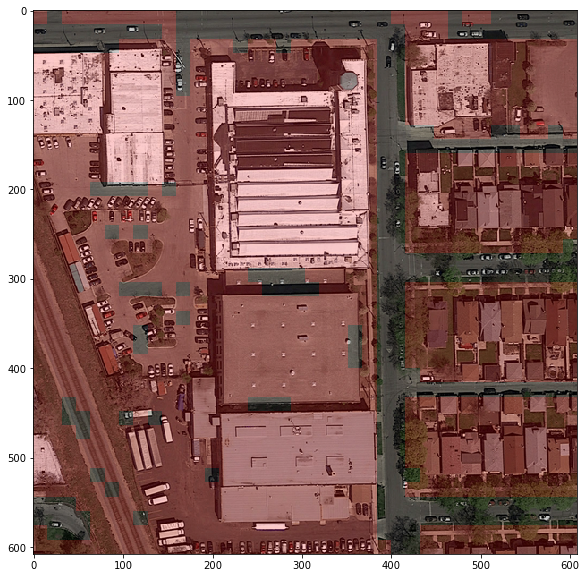

In [7]:
# Run prediction on the img_idx-th image (from the test set)
img_idx = 2 # This value can be changed

test_dir = "test_set_images/test_"
direc = test_dir + str(img_idx) + "/test_" + str(img_idx) + ".png"
Xi = extract_img_features(direc, stride)

Zi = model.model.predict(Xi)
Zi = Zi[:,0] > Zi[:,1]

img_ = load_image(direc)
w = img_.shape[0]
h = img_.shape[1]

predicted_im = label_to_img(w, h, patch_size, patch_size, Zi, stride)
cimg = concatenate_images(img_, predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(img_, predicted_im)
plt.imshow(new_img)

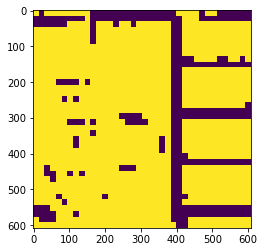

In [10]:
plt.figure()
plt.imshow(predicted_im)

# Generate submission

In [11]:
# -*- coding: utf-8 -*-
model = CNN()
model.load('best.h5')

submission_filename = 'submission.csv'
image_filenames = []
for i in range(1, 51):
    image_filename = 'test_set_images/test_'+str(i)+'/test_' + str(i) + '.png'
    image_filenames.append(image_filename)
    

generate_submission(model, submission_filename, *image_filenames)

C:\Users\glagl\.conda\envs\ML2\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), input_shape=(72, 72, 3..., padding="same")`
C:\Users\glagl\.conda\envs\ML2\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), padding="same")`
C:\Users\glagl\.conda\envs\ML2\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
C:\Users\glagl\.conda\envs\ML2\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), padding="same")`
C:\Users\glagl\.conda\envs\ML2\lib\site-packages\ipykernel_launcher.py:42: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), padding="same")`
C:\Users\glagl\.conda\envs\ML2\lib\site-packages\ipykernel_launcher.py:45: UserW

Processing test_set_images/test_1/test_1.png
Processing test_set_images/test_2/test_2.png
Processing test_set_images/test_3/test_3.png
Processing test_set_images/test_4/test_4.png
Processing test_set_images/test_5/test_5.png
Processing test_set_images/test_6/test_6.png
Processing test_set_images/test_7/test_7.png
Processing test_set_images/test_8/test_8.png
Processing test_set_images/test_9/test_9.png
Processing test_set_images/test_10/test_10.png
Processing test_set_images/test_11/test_11.png
Processing test_set_images/test_12/test_12.png
Processing test_set_images/test_13/test_13.png
Processing test_set_images/test_14/test_14.png
Processing test_set_images/test_15/test_15.png
Processing test_set_images/test_16/test_16.png
Processing test_set_images/test_17/test_17.png
Processing test_set_images/test_18/test_18.png
Processing test_set_images/test_19/test_19.png
Processing test_set_images/test_20/test_20.png
Processing test_set_images/test_21/test_21.png
Processing test_set_images/test